In [1]:
from google.colab import drive
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_numeric
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
from sklearn.manifold import TSNE

from absl import logging
from sklearn import svm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/CSC522
!pwd
print('done')

Mounted at /content/drive
/content
done


In [42]:
all = pd.read_csv("/content/drive/MyDrive/CSC522/data/combined_generalized_rating.csv", index_col="Unnamed: 0").dropna()

In [ ]:
# ## Import data from "shared with me" folder
# drive.mount("/ShardDrives/")
# all = pd.read_csv("/ShardDrives/MyDrive/CSC522/data/combined.csv", index_col="Unnamed: 0")

In [43]:
all.head()

,product,title,rating,body,generalized_rating
0,"elago Compatible with iPhone 13 Pro Max Case, ...",Perfect Apple Silicone Case Replacement,5,My favorite case for my phone was the eucalypt...,1
1,"elago Compatible with iPhone 13 Pro Max Case, ...",Simply Perfect!,5,Hot Pink! Just put this on my phone & I’m tick...,1
2,"elago Compatible with iPhone 13 Pro Max Case, ...",Love it. Not sure if it will handle a fall though,4,Love it. So cute. Love the feeling of it. What...,1
3,"elago Compatible with iPhone 13 Pro Max Case, ...",I took one star away for..,4,The only issue with this case is that it is ha...,1
4,"elago Compatible with iPhone 13 Pro Max Case, ...",16 year old very happy with her choice.,5,Product arrived on time as described. Our sixt...,1


In [5]:
## check whether Nan exists
all.isnull().any()

product               False
title                 False
rating                False
body                  False
generalized_rating    False
dtype: bool

<Axes: xlabel='generalized_rating', ylabel='Count'>

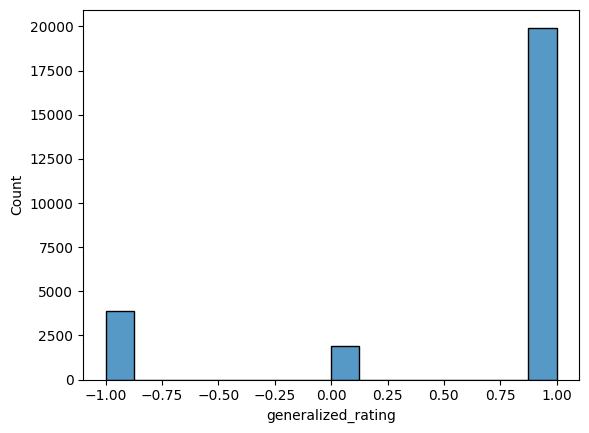

In [44]:
sns.histplot(all["generalized_rating"])

<Axes: xlabel='Number of reviews per product', ylabel='Density'>

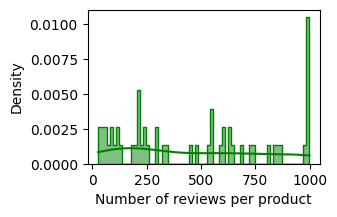

In [89]:
group = all.groupby("product").count()
plt.figure(figsize=(3, 2))
plt.xlabel("Number of reviews per product")
sns.histplot(x=group["rating"], stat="density", bins=70, color="g", kde=True, element="step")


<Axes: xlabel='generalized_rating', ylabel='len'>

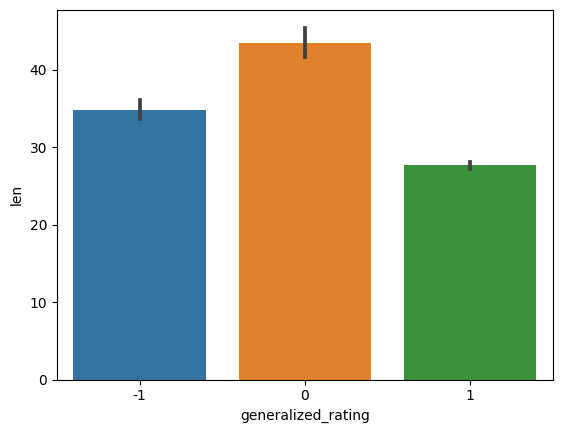

In [13]:
# Mean of sentence length for each rate
for i, b in enumerate(all["body"]):
  all.loc[i, "len"] = len(b.split(" "))

sns.barplot(x="generalized_rating", y="len", data=all)

In [38]:
group.head()["generalized_rating"]

product
MOSNOVO for iPhone XR Case, Clear Slim Soft TPU + PC Shockproof Protective Phone Cover with Black White Tulips Floral Design Case for iPhone XR 6.1&#34;                                               0.919118
ESR for iPhone 11 Phone Case, iPhone 11 Case Clear, Military-Grade Protection, Shock-Absorbing Corners, Scratch- and Yellowing-Resistant Hard Back, Phone Case for iPhone 11, Air Armor Case, Clear    0.895792
Elando Crystal Clear Phone Case Compatible with iPhone 12/12 Pro, Non-Yellowing Shockproof Protective Phone Case Slim Thin, 6.1 inch                                                                   0.893467
Miracase Liquid Silicone Case Compatible with iPhone 11 6.1 inch(2019), Gel Rubber Full Body Protection Shockproof Cover Case Drop Protection Case (Clove Purple)                                      0.876754
Chirano Case Compatible with iPhone 11, Only for 6.1 inch, Clear,4 Corners Shockproof Protection                                                                

In [39]:
group.tail()["generalized_rating"]

product
KUMTZO Compatible with iPhone 11 Leopard of The Night Print Case, Fashion Black Leopard Cheetah Pattern Protective Cover for Women Girls Men Boys with for iPhone 11 6.1 Inch    0.281690
LucBuy Game Console Case for iPhone, Retro Protective Cover Self-Powered Case with 36 Small Game,Full Color Display,Shockproof Video Game Case for iPhone XR - Pink              0.256579
TEAUGHT Case for iPhone 12 Pro Max, Soft TPU Black Plating with Adjustable Wristband Kickstand Slim Thin Cover Anti-Scratch Shockproof Protective Case for Women Girls Men       0.007752
Caseative Love Heart Laser Bling Glitter Clear Soft Compatible with iPhone Case for Women Girls (Clear,iPhone 13)                                                               -0.003817
Apple iPhone 12 and iPhone 12 Pro Silicone Case with MagSafe - Black                                                                                                            -0.084765
Name: generalized_rating, dtype: float64

<Axes: xlabel='generalized_rating', ylabel='product'>

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120814 (\N{MATHEMATICAL SANS-SERIF BOLD DIGIT TWO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120812 (\N{MATHEMATICAL SANS-SERIF BOLD DIGIT ZERO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120393 (\N{MATHEMATICAL SANS-SERIF BOLD ITALIC CAPITAL N}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120384 (\N{MATHEMATICAL SANS-SERIF BOLD ITALIC CAPITAL E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120402 (\N{MATHEMATICAL SANS-SERIF BOLD ITALIC CAPITAL W}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages

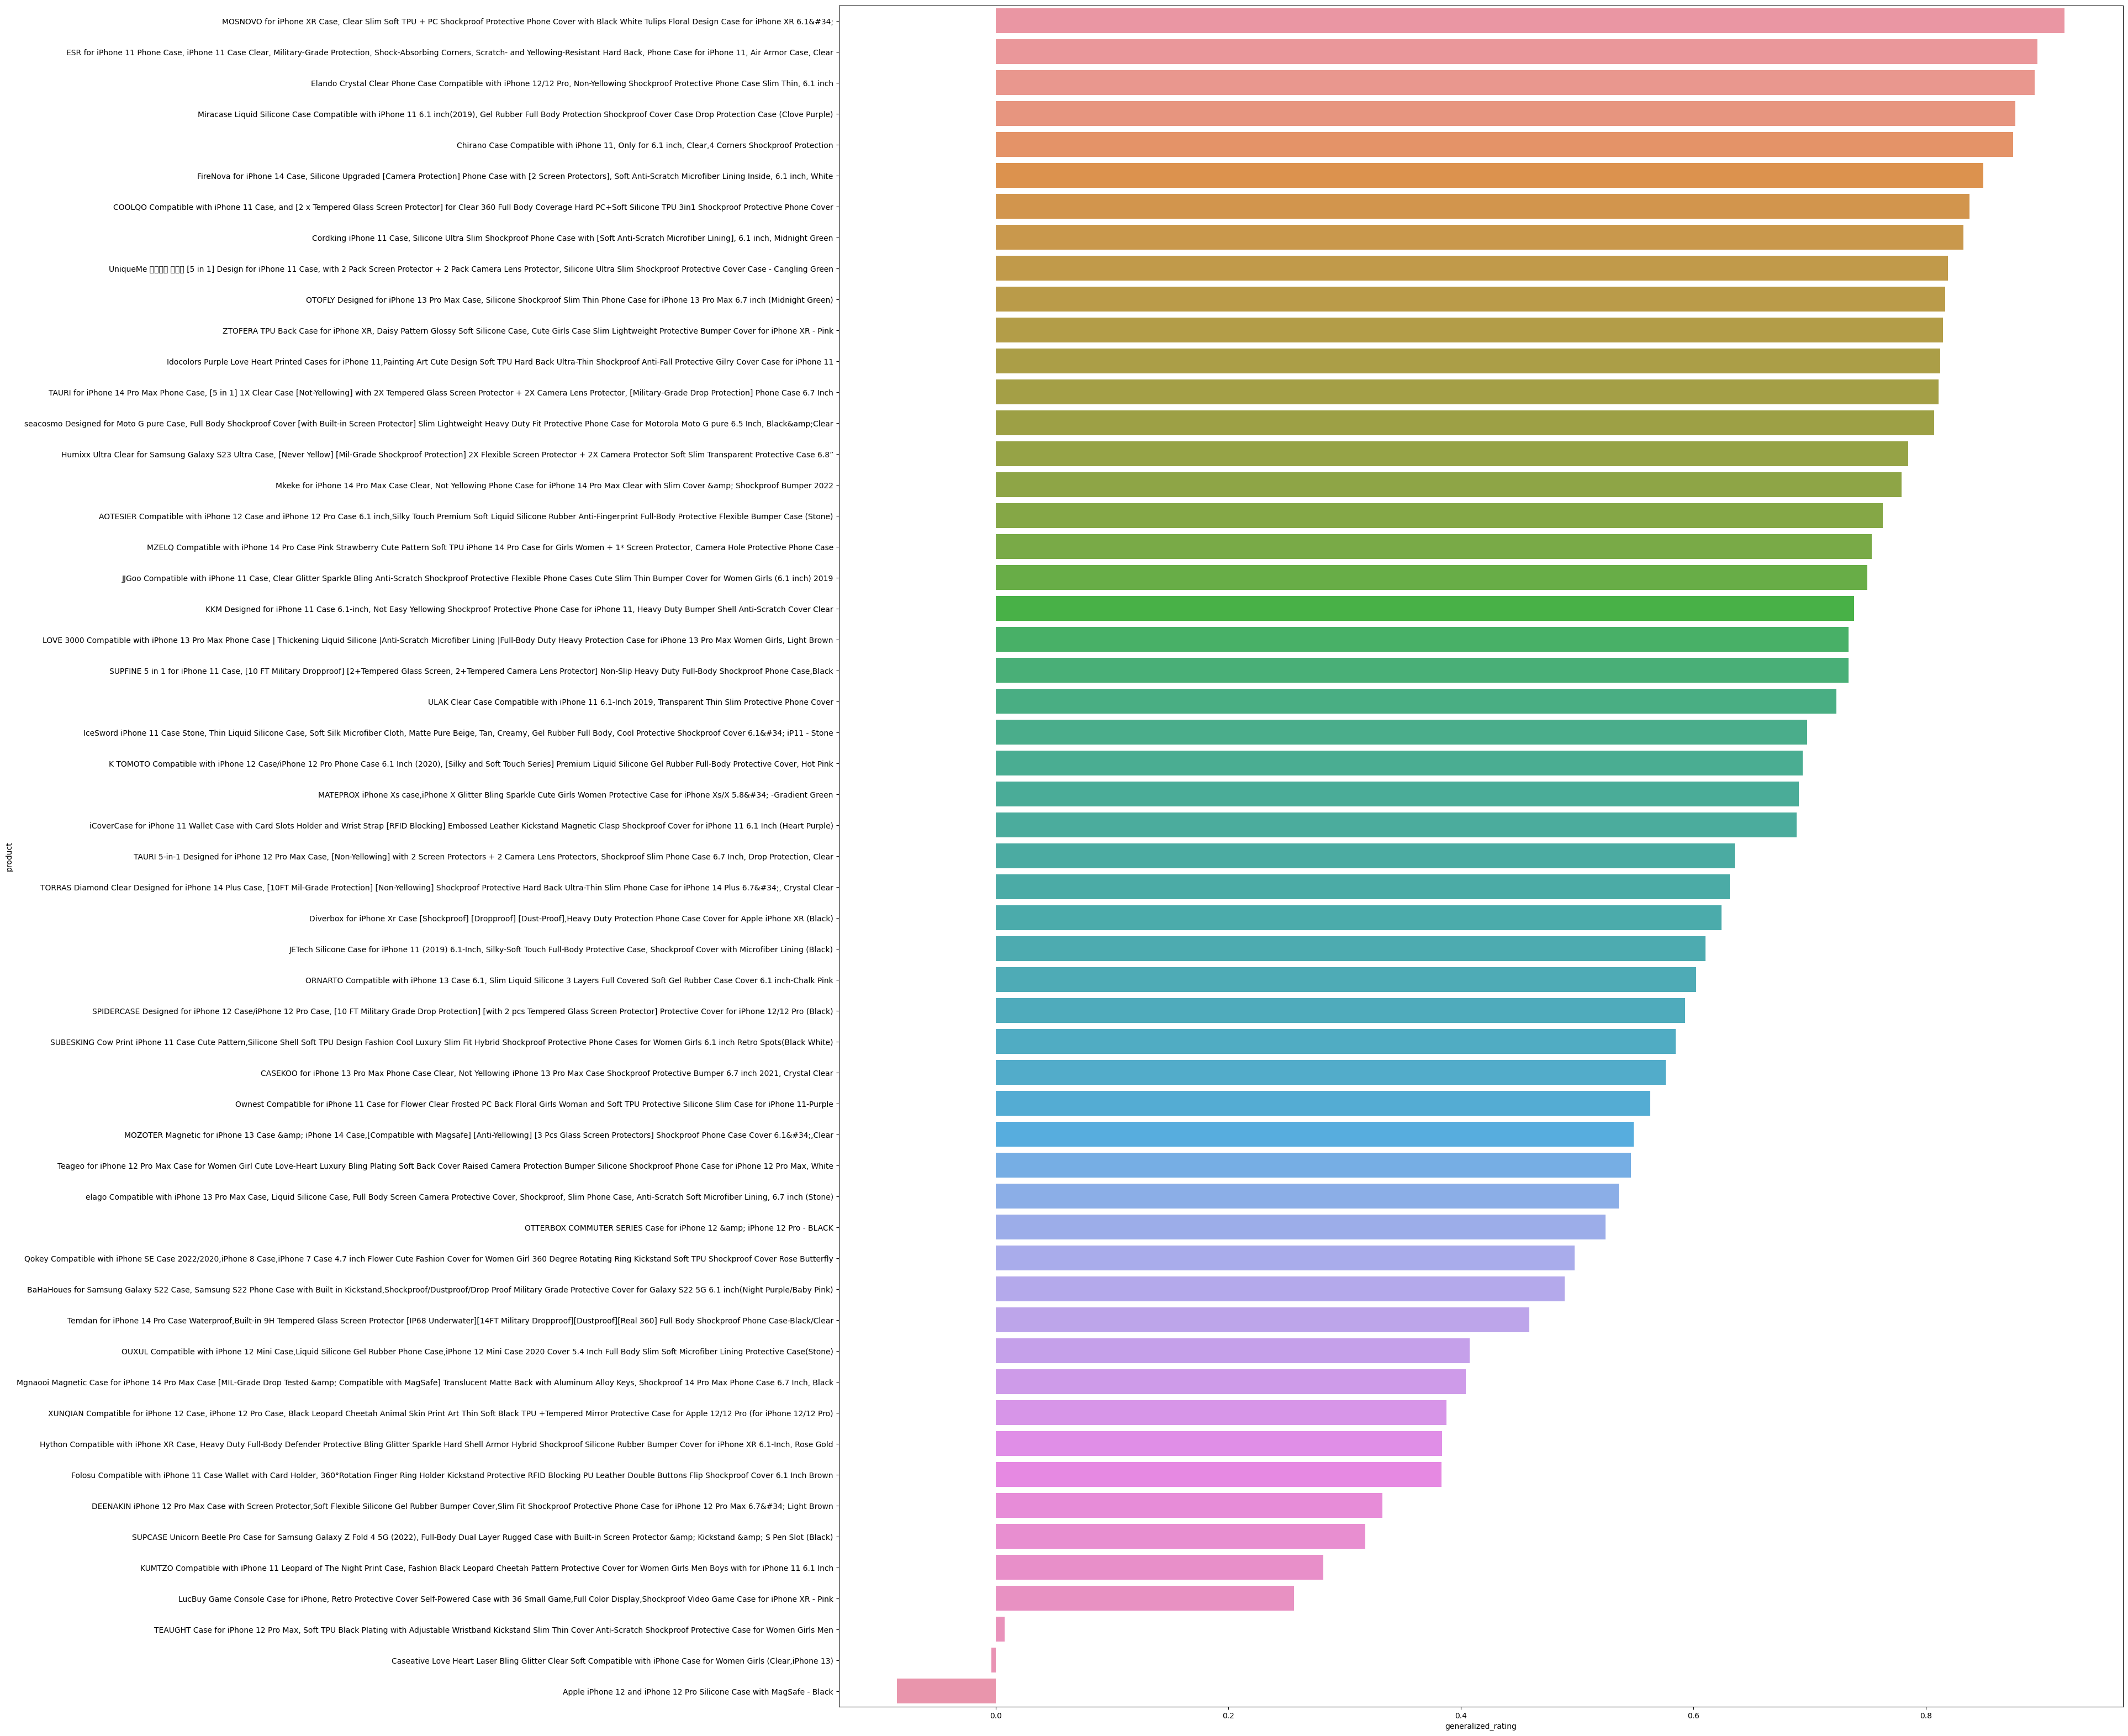

In [36]:
# Mean of sentence length for each rate
group = all.groupby("product").mean()
group = group.sort_values("generalized_rating", ascending=False)

plt.figure(figsize=(30, 40))
sns.barplot(x="generalized_rating", y=group.index, data=group, orient='h')

In [45]:
# Load tensor flow universal sentence encoder model
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [46]:
#preprocess function
def preprocess(data):
  lines = []
  for n, row in data.iterrows():
    try:
      review = row["body"]
      
      # preprocess here
      CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
      review = " ".join(preprocess_string(review, CUSTOM_FILTERS))
      lines.append(review)
    except:
      lines.append(review)
  return lines

In [ ]:
train=all.sample(frac=0.8,random_state=200)
test=all.drop(train.index)

messages = preprocess(train)

In [ ]:
messages[0]

'i agree with other reviewers that the material is almost too sticky it doesn t slide in pockets well and collects dust i ordered red which is so bright that it almost looks neon it also feels too thick and bulky which is fine if that s what you want but this on top of a larger phone that i had makes the phone difficult to hold and navigate with one hand very durable and sturdy though seems well made'

In [ ]:
messages[0]

"I agree with other reviewers that the material is almost too sticky - it doesn't slide in pockets well and collects dust.I ordered Red which is so bright that it almost looks neon. It also feels too thick and bulky - which is fine if that's what you want  - but this on top of a larger phone that I had makes the phone difficult to hold and navigate with one hand.Very durable and sturdy though. Seems well made."

In [58]:
# Preprocess data
train=all.sample(frac=0.8,random_state=200)
test=all.drop(train.index)

messages = preprocess(train)
messages_test = preprocess(test)

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

# create embeddings for the data
def create_embeddings(messages_list):
  return np.array(embed(messages_list))

# create x train and test
x_train = create_embeddings(messages)
x_test = create_embeddings(messages_test)

In [59]:
# get target manual labels
def get_target_labels(data, cat):
  list = []
  for n, row in data.iterrows():
    list.append(int(row[cat]))
  return list

y_train = get_target_labels(train, "generalized_rating")
y_test = get_target_labels(test, "generalized_rating")

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def analyze_resuts(x_train, y_train, x_test, y_test):
    # clf = KNeighborsClassifier(n_neighbors=4)
    # clf = DecisionTreeClassifier(random_state=10)
    # clf = RandomForestClassifier(random_state=10)
    clf = AdaBoostClassifier(random_state=10)

    clf.fit(x_train, y_train)

    acc1 = clf.score(x_train, y_train)
    acc2 = clf.score(x_test, y_test)

    print("Baseline accuracy: " + str(acc1))
    print("Tested accuracy: " + str(acc2))

    y_pred = clf.predict(x_test)

    labels = [-1,0,1]

    report = sklearn.metrics.classification_report(
        y_test, y_pred, digits=3, labels=labels
    )

    print("Classification report:")
    print(report)

    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=labels)
    return clf

In [50]:
clf = analyze_resuts(x_train, y_train, x_test, y_test)

Baseline accuracy: 0.8327911831820168
Tested accuracy: 0.8391920761312877
Classification report:
              precision    recall  f1-score   support

          -1      0.638     0.632     0.635       794
           0      0.247     0.058     0.095       359
           1      0.888     0.950     0.918      3996

    accuracy                          0.839      5149
   macro avg      0.591     0.547     0.549      5149
weighted avg      0.805     0.839     0.817      5149



In [ ]:
aa = create_embeddings(preprocess(all[:100]))
prediction = clf.predict(aa)
for i, pred in enumerate(prediction):
  if pred != all["generalized_rating"][i]:
    print(f"Predicted Label: {pred}\t True Label:{all['generalized_rating'][i]}")
    print(f"Data: {all['body'][i]}\n\n")

Predicted Label: -1	 True Label:1
Data: The only issue with this case is that it is hard to get in  and out of a pocket.  It isn't sticky in the fact that it gets dirty but it has no slide to it to get in and out of pockets.  It just sticks


Predicted Label: 0	 True Label:1
Data: The color is just like the picture, the material is very nice. It doesn’t look or feel cheap. The only thing is that because of the material it collects dirt and grime.


Predicted Label: 0	 True Label:1
Data: This case is worth every penny! The color is very pretty. I ordered in the color stone. The case does feel “grippy” and saw a few people knock off a few stars because lint or hair kept sticking to the phone but honestly ignore those reviews. It is a silicone phone case after all & it is the whole point of choosing this type of case. I wipe my phone with an alcohol wipe daily so anything that might be on there gets cleaned away & voila it’s like brand new. This case also feels very soft & easy to hold. H

<Axes: >

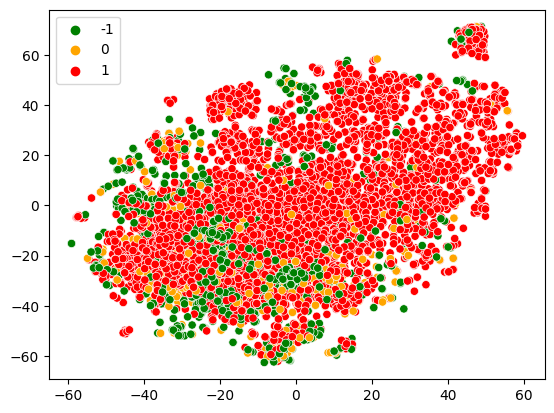

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x_test)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_test, palette=['green','orange', "red"])

<Axes: >

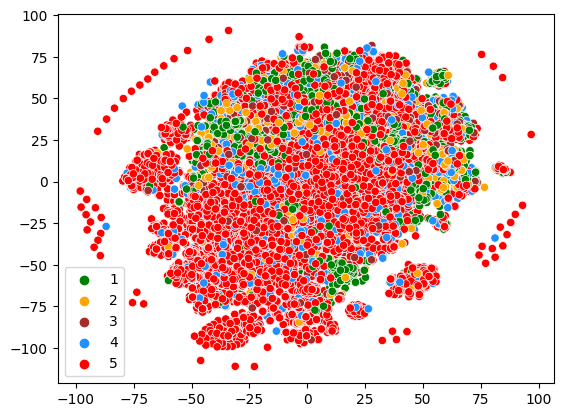

In [ ]:
sample = embedding_df #.groupby("rating").sample(n=50, random_state=2023)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.loc[:, sample.columns!="rating"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sample["rating"].values, palette=['green','orange','brown','dodgerblue','red'])

<Axes: >

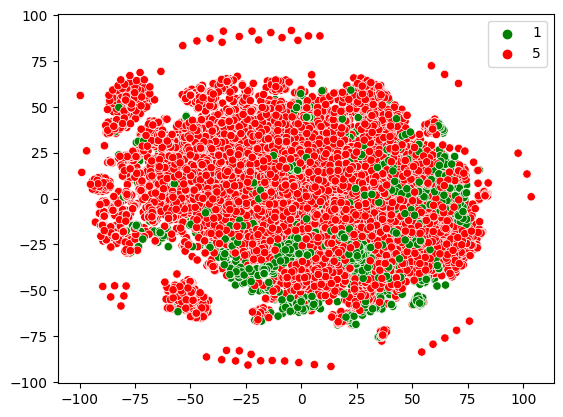

In [ ]:
sample = embedding_df.loc[(embedding_df["rating"] == 1) | (embedding_df["rating"] == 5)]
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.loc[:, sample.columns!="rating"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sample["rating"].values, palette=['green', 'red'])

<Axes: >

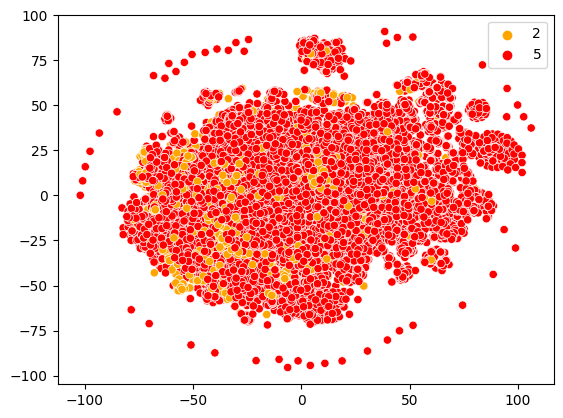

In [ ]:
sample = embedding_df.loc[(embedding_df["rating"] == 2) | (embedding_df["rating"] == 5)]
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.loc[:, sample.columns!="rating"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sample["rating"].values, palette=['orange', 'red'])

<Axes: >

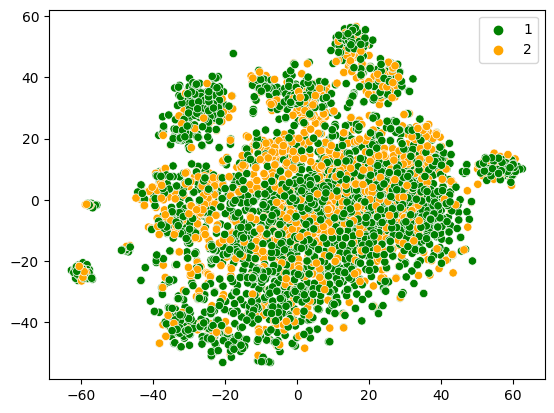

In [ ]:
sample = embedding_df.loc[(embedding_df["rating"] == 1) | (embedding_df["rating"] == 2)]
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.loc[:, sample.columns!="rating"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sample["rating"].values, palette=["green", 'orange'])

<Axes: >

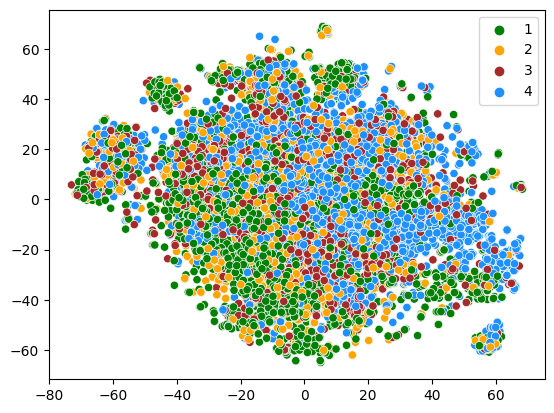

In [ ]:
sample = embedding_df.loc[embedding_df["rating"] != 5]
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.loc[:, sample.columns!="rating"])

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sample["rating"].values, palette=['green','orange','brown','dodgerblue'])